In [4]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)
    

In [5]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)


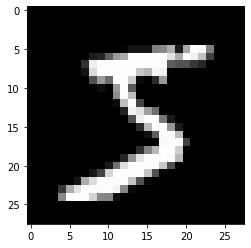

In [6]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape)

In [7]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [8]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [9]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [11]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.4589, -2.4540, -2.7824, -1.6913, -2.3351, -2.3979, -2.2037, -2.0698,
        -2.3926, -2.7081], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [12]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [13]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3277, grad_fn=<NegBackward0>)


In [14]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [15]:
print(accuracy(preds, yb))

tensor(0.1094)


In [16]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0833, grad_fn=<NegBackward0>) tensor(1.)


In [18]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [20]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0833, grad_fn=<NllLossBackward0>) tensor(1.)


In [25]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(784, 10) / math.sqrt(784)
        )
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [26]:
model = Mnist_Logistic()

In [27]:
print(loss_func(model(xb), yb))

tensor(2.4205, grad_fn=<NllLossBackward0>)


In [28]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [30]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit()

In [31]:
print(loss_func(model(xb), yb))

tensor(0.0818, grad_fn=<NllLossBackward0>)


In [32]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [33]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3323, grad_fn=<NllLossBackward0>)


In [34]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0808, grad_fn=<NllLossBackward0>)


In [35]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(2.2730, grad_fn=<NllLossBackward0>)
tensor(0.0818, grad_fn=<NllLossBackward0>)


In [36]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

In [37]:
xb, yb = train_ds[i * bs: i * bs + bs]
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))        

tensor(0.0809, grad_fn=<NllLossBackward0>)


In [38]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [39]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward0>)


In [40]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2, shuffle=False)

In [41]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb)
                         for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2933)
1 tensor(0.2765)


In [42]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [43]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb)
                  for xb, yb in valid_dl]
            )
            
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            
            print(epoch, val_loss)

In [44]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [45]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4548776521921158
1 0.31449235265254977


In [46]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.conv3 = nn.Conv2d(16, 10, 3, 2, 1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
lr = 0.1

In [47]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33876841807365415
1 0.2523984684467316


In [48]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    

def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [49]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, 3, 2, 1),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, 2, 1),
    nn.ReLU(),
    nn.Conv2d(16, 10, 3, 2, 1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3491084086179733
1 0.2645842485845089


In [50]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


# moving initial lambda layer into a generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [51]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, 2, 1),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, 2, 1),
    nn.ReLU(),
    nn.Conv2d(16, 10, 3, 2, 1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [52]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.334664692401886
1 0.25252704541683196


In [53]:
print(torch.cuda.is_available())

False


In [54]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [55]:
dev

device(type='cpu')

In [56]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [57]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.20928660626411438
